In [4]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [5]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]

# train_f4 = pd.read_csv('../input/f4_train.csv', index_col='TransactionID')
# test_f4 = pd.read_csv('../input/f4_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 46.7 s, sys: 4.04 s, total: 50.7 s
Wall time: 50.7 s


In [6]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [7]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [8]:
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
    
for col in [["card1",["addr1","card2","P_emaildomain"]],["card2",["addr1","P_emaildomain"]]]:
    for col2 in col[1]:
        train_transaction['next'+col[0]+col2] = train_transaction.groupby(col[0])[col2].shift(-1)
        train_transaction['next'+col[0]+col2] = (train_transaction['next'+col[0]+col2] == train_transaction[col2]).astype(int)
        test_transaction['next'+col[0]+col2] = test_transaction.groupby(col[0])[col2].shift(-1)
        test_transaction['next'+col[0]+col2] = (test_transaction['next'+col[0]+col2] == test_transaction[col2]).astype(int)            
#     s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())

# for col in "card1,card2,card3,card5,addr1,addr2".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     for i in range(bin):
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

# train_transaction["addr2"] = train_transaction["addr1"].map(str) + "_" + train_transaction["addr2"].map(str)
# test_transaction["addr2"] = test_transaction["addr1"].map(str) + "_" + test_transaction["addr2"].map(str)
    
#     col_count = train_test.groupby(col)['TransactionDT'].count().fillna(0)
#     col_count = col_count.reset_index()
#     col_count.columns = col + ["_".join(col)+'_count']
#     index = train_transaction.index
#     train_transaction = train_transaction.merge(col_count, how='left', on = col)
#     train_transaction.index = index
#     index = test_transaction.index
#     test_transaction = test_transaction.merge(col_count, how='left', on = col)
#     test_transaction.index = index


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

# train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
# train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
# train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

C1
-1.0            3
 0.0         5291
 1.0       586742
 2.0       197520
 3.0        96569
 4.0        53794
 5.0        32851
 6.0        19774
 7.0        12984
 8.0         9068
 9.0         6383
 10.0        4873
 11.0        3736
 12.0        3187
 13.0        2399
 14.0        1921
 15.0        1515
 16.0        1356
 17.0        1293
 18.0        1120
 19.0         894
 20.0         868
 21.0         712
 22.0         717
 23.0         492
 24.0         563
 25.0         525
 26.0         401
 27.0         431
 28.0         415
            ...  
 4629.0         1
 4630.0         1
 4631.0         1
 4632.0         1
 4633.0         1
 4635.0         1
 4642.0         1
 4643.0         1
 4644.0         1
 4645.0         3
 4651.0         1
 4653.0         1
 4654.0         1
 4655.0         1
 4658.0         2
 4660.0         4
 4661.0         2
 4662.0         1
 4663.0         3
 4665.0         1
 4666.0         1
 4667.0         2
 4668.0         1
 4669.0         1
 4670.0

C9
-1.0           3
 0.0      341561
 1.0      420354
 2.0      146643
 3.0       64015
 4.0       31672
 5.0       16483
 6.0       10670
 7.0        6499
 8.0        4712
 9.0        3351
 10.0       2128
 11.0       1871
 12.0       1395
 13.0       1123
 14.0        938
 15.0        786
 16.0        597
 17.0        522
 18.0        460
 19.0        524
 20.0        366
 21.0        369
 22.0        340
 23.0        251
 24.0        269
 25.0        200
 26.0        205
 27.0        182
 28.0        230
           ...  
 528.0         4
 535.0         2
 537.0         1
 539.0         1
 540.0         7
 543.0         2
 544.0         2
 545.0         1
 549.0         1
 550.0         2
 551.0         1
 553.0         1
 554.0         4
 555.0         2
 557.0         1
 558.0        10
 559.0         3
 560.0         2
 561.0         1
 562.0         1
 563.0         1
 564.0         6
 565.0         3
 566.0         9
 567.0         9
 568.0         1
 569.0         1
 570.0     

In [10]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [11]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5',
       ...
       'card2_addr1', 'card3', 'card4', 'card5', 'card6', 'dist1', 'dist2',
       'hour', 'isFraud', 'weekday'],
      dtype='object', length=399)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [12]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_12
Found        42220
NotFound    243920
Name: id_01, dtype: int64
id_13
 34.0         1
 50.0         1
 40.0         1
 29.0         1
 23.0         1
 59.0         1
 10.0         1
 12.0         2
 26.0         2
 46.0         3
 47.0         3
 60.0         3
 37.0         3
 57.0         3
 17.0         3
 16.0         3
 53.0         4
 22.0         5
 21.0         8
 30.0         9
 42.0         9
 32.0        10
 48.0        12
 58.0        17
 56.0        19
 13.0        21
 38.0        22
 36.0        25
 45.0        26
 31.0        38
 39.0        45
 54.0        67
 28.0        77
 44.0        87
 61.0       108
 35.0       317
 51.0       349
 15.0       520
 24.0       531
 55.0       781
 11.0       890
 43.0       907
 41.0      1086
 19.0      1147
 18.0      1218
 25.0      1302
 62.0      1752
 63.0      2050
 20.0      3804
 14.0      6427
 33.0     10048
 64.0     14429
 49.0     26365
-1.0      28534
 27.0     73282
 52.0    109760
Name: id_01, dtype: int64
id

id_26
 210.0         1
 127.0         1
 172.0         1
 173.0         1
 132.0         1
 175.0         1
 181.0         1
 187.0         1
 115.0         1
 207.0         1
 112.0         1
 160.0         1
 154.0         1
 214.0         1
 196.0         1
 101.0         1
 105.0         1
 139.0         1
 104.0         1
 198.0         1
 193.0         2
 170.0         2
 125.0         2
 123.0         2
 140.0         2
 179.0         2
 145.0         2
 195.0         2
 165.0         2
 208.0         3
           ...  
 177.0        36
 134.0        39
 138.0        40
 156.0        42
 106.0        44
 163.0        45
 150.0        48
 133.0        53
 143.0        56
 149.0        67
 168.0        74
 117.0        78
 162.0        89
 194.0       120
 190.0       135
 121.0       176
 146.0       179
 182.0       225
 215.0       228
 216.0       352
 169.0       410
 137.0       441
 147.0       547
 102.0       583
 119.0       669
 100.0       891
 142.0      1126
 184.0  

In [13]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [14]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [15]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f4, how='left', left_index=True, right_index=True)
# test = test.merge(test_f4, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x*(3600*24*7)))
test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x*(3600*24*7)))

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 566)
(506691, 565)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [16]:
print(X_train.shape,X_test.shape)

(590540, 566) (506691, 566)


In [17]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 2574.60 MB
Memory usage after optimization is: 794.38 MB
Decreased by 69.1%
Memory usage of dataframe is 2211.88 MB
Memory usage after optimization is: 692.16 MB
Decreased by 68.7%
CPU times: user 4min 50s, sys: 12min 40s, total: 17min 30s
Wall time: 17min 30s


In [18]:
# X_train2 = X_train.copy()
# X_train2['isFraud'] = y_train
# X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# y_train2 = X_train2['isFraud']
# del X_train2['isFraud'],X_train2['hour2'] 


temp = X_train[['TransactionDT','TransactionAmt']].values
folds_index = [([],[]),([],[]),([],[])]
cache = {}
for i in range(temp.shape[0]):
    amt = temp[i,1]
    cache[amt] = cache.get(amt,[])
    cache[amt].append(i)
    l = len(cache[amt])
    folds_num = (int(amt*1000)+l)%3
    folds_index[folds_num][1].append(i)
    for j in range(3):
        if j != folds_num:
            folds_index[j][0].append(i)

for i in range(3):
    folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
    print(folds_index[i],len(folds_index[i][0]))
    


(array([     0,      4,      5, ..., 472429, 472430, 472431]), array([     1,      2,      3, ..., 472421, 472427, 472428])) 314947
(array([     0,      1,      2, ..., 472428, 472429, 472430]), array([     4,      6,      8, ..., 472423, 472425, 472431])) 314969
(array([     1,      2,      3, ..., 472427, 472428, 472431]), array([     0,      5,      7, ..., 472426, 472429, 472430])) 314948


In [22]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":12,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.9,
        "min_child_weight":2,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9720201821373916
debug: 0.928459709448377 0.08382409801655318
ROC AUC 0.9724902736981865
debug: 0.930962997566625 0.08507598816460055
ROC AUC 0.9728098824252669
debug: 0.9274510278892909 0.08388660250504125
debug: 0.9349693339109066 0.0820568411582461
CPU times: user 5min 43s, sys: 3min 20s, total: 9min 3s
Wall time: 9min 4s


In [23]:
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_test_pred['pred'] = y_preds
# X_test_pred['rank'] =  X_test_pred['pred'].rank()

# true_size = 500
# X_test_psu_index = X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)].index
# X_test_psu,y_test_psu = X_test.loc[X_test_psu_index, :], X_test_pred.loc[X_test_psu_index,'pred'].map(lambda x:1 if x > 0.10 else 0)
# X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)]

In [24]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
565 TransactionDT2 55853280000 55835136000 55853280000 55835136000 [0.99397886 0.01952318]
564 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99439996 0.01952318]
563 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.99440867 0.01952318]
562 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.99450797 0.01952318]
561 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.99450797 0.01952318]
560 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.99450797 0.01952318]
559 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.99450797 0.01952318]
558 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.99450797 0.01952318]
557 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.99430084 0.01952318]
556 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.9944048  0.01952318]
555 id_31_count 926.0 23650.0 926.0 23655.0 [0.9930736  0.01952318]
554 id_30_count 42170.0 711.0 42170.0 711.0 [

447 card5_amtcount 239.4 109.75 239.39957093206937 109.73055974494146 [0.9844791  0.01952318]
446 card2_C13count 0.9194 2.725 0.9192280496211549 2.724731987807521 [0.98547953 0.01952318]
445 card2_C8count 0.842 0.10004 0.8415958016554217 0.10002477830050692 [0.9842397  0.01952318]
444 card2_C5count 0.3198 0.957 0.31986125129721504 0.9569497907271255 [0.9831298  0.01952318]
443 card2_amtcount 237.2 136.4 237.21384720725786 136.37239332528506 [0.98185515 0.01952318]
442 card1_C13count 0.8096 0.4988 0.809498111171074 0.49875311720698257 [0.9786497  0.01952318]
441 card1_C8count 1.67 1.99 1.6696897818706107 1.9900497512437814 [0.9786497  0.01952318]
440 card1_C5count 0.1344 nan 0.1343846959546254 nan [0.98074037 0.01952318]
439 nextcard2P_emaildomain 0 0 0 0 [0.98074037 0.01952318]
438 nextcard2addr1 0 0 0 0 [0.98074037 0.01952318]
437 nextcard1P_emaildomain 1 0 1 0 [0.9793823  0.01952318]
436 nextcard1card2 1 1 1 1 [0.9793823  0.01952318]
435 nextcard1addr1 0 1 0 1 [0.97186613 0.01952318]

300 V248 4.0 1.0 4.0 1.0 [0.9471609  0.01952318]
299 V247 4.0 1.0 4.0 1.0 [0.9471609  0.01952318]
298 V246 4.0 1.0 4.0 1.0 [0.95097375 0.01952318]
297 V245 0.0 1.0 0.0 1.0 [0.95097375 0.01952318]
296 V244 4.0 1.0 4.0 1.0 [0.94328964 0.01952318]
295 V243 4.0 1.0 4.0 1.0 [0.9345587  0.01952318]
294 V242 4.0 1.0 4.0 1.0 [0.9345587  0.01952318]
293 V241 1.0 1.0 1.0 1.0 [0.9345587  0.01952318]
292 V240 1.0 1.0 1.0 1.0 [0.9345587  0.01952318]
291 V239 0.0 0.0 0.0 0.0 [0.9345587  0.01952318]
290 V238 0.0 0.0 0.0 0.0 [0.9345587  0.01952318]
289 V237 2.0 0.0 2.0 0.0 [0.9345587  0.01952318]
288 V236 2.0 0.0 2.0 0.0 [0.9345587  0.01952318]
287 V235 2.0 0.0 2.0 0.0 [0.9360337  0.01952318]
286 V234 4.0 0.0 4.0 0.0 [0.9380049  0.01952318]
285 V233 1.0 0.0 1.0 0.0 [0.9380049  0.01952318]
284 V232 1.0 0.0 1.0 0.0 [0.9380049  0.01952318]
283 V231 1.0 0.0 1.0 0.0 [0.9380049  0.01952318]
282 V230 4.0 1.0 4.0 1.0 [0.9380049  0.01952318]
281 V229 4.0 1.0 4.0 1.0 [0.9380049  0.01952318]
280 V228 4.0 1.0 4.0

132 V80 nan 0.0 nan 0.0 [0.87587696 0.01952318]
131 V79 nan 0.0 nan 0.0 [0.8711488  0.01952318]
130 V78 nan 0.0 nan 0.0 [0.86888456 0.01952318]
129 V77 nan 0.0 nan 0.0 [0.87256575 0.01952318]
128 V76 nan 0.0 nan 0.0 [0.87256575 0.01952318]
127 V75 nan 0.0 nan 0.0 [0.87256575 0.01952318]
126 V74 nan nan nan nan [0.87256575 0.01952318]
125 V73 nan nan nan nan [0.87256575 0.01952318]
124 V72 nan nan nan nan [0.87256575 0.01952318]
123 V71 nan nan nan nan [0.87256575 0.01952318]
122 V70 nan nan nan nan [0.87256575 0.01952318]
121 V69 nan nan nan nan [0.87256575 0.01952318]
120 V68 nan nan nan nan [0.87256575 0.01952318]
119 V67 nan nan nan nan [0.87256575 0.01952318]
118 V66 nan nan nan nan [0.87256575 0.01952318]
117 V65 nan nan nan nan [0.87256575 0.01952318]
116 V64 nan nan nan nan [0.87256575 0.01952318]
115 V63 nan nan nan nan [0.87256575 0.01952318]
114 V62 nan nan nan nan [0.87256575 0.01952318]
113 V61 nan nan nan nan [0.87256575 0.01952318]
112 V60 nan nan nan nan [0.87256575 0.01

In [25]:
features = [x for x in X_train.columns if (x not in col_del and  not x.startswith("w2v") and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1]
    y_preds11+= temp / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5)) 

ROC AUC 0.9698917068468935
debug: 0.9304818462887097 0.08134015404988455
ROC AUC 0.9702886445325895
debug: 0.9309750068491315 0.08243799019555512
ROC AUC 0.970755415563994
debug: 0.9280729775401648 0.08222032715917882
debug: 0.935512731289374 0.08002452207787303
debug: 0.9360108878062535 0.08054332177499059


In [26]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.0966,V258
0.0247,V244
0.0219,V70
0.0207,V91
0.0188,V257
0.0164,V189
0.0146,C1_count
0.0110,V294
0.0106,C14
0.0099,C4_count


In [27]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[-100:].index)
# print(cols)
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:100].index)
# print(cols)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,25))
# sns.barplot(x="importance",
#             y="Feature",
#             data=best_features.sort_values(by="importance",
#                                            ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [29]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT']] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in ['card1_TransactionAmt', 'card1_addr1','card1_card2'] 
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.1, 'lambda_l2': 0.01, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.947135	valid_0's binary_logloss: 0.0722526	valid_1's auc: 0.90178	valid_1's binary_logloss: 0.0938485
[150]	valid_0's auc: 0.968803	valid_0's binary_logloss: 0.0470429	valid_1's auc: 0.917214	valid_1's binary_logloss: 0.0853929
[180]	valid_0's auc: 0.969649	valid_0's binary_logloss: 0.0458193	valid_1's auc: 0.917095	valid_1's binary_logloss: 0.0860588
[210]	valid_0's auc: 0.970285	valid_0's binary_logloss: 0.0450443	valid_1's auc: 0.917239	valid_1's binary_logloss: 0.0866449
[240]	valid_0's auc: 0.970623	valid_0's binary_logloss: 0.0444721	valid_1's auc: 0.917249	valid_1's binary_logloss: 0.0873653
[270]	valid_0's auc: 0.970872	valid_0's binary_logloss: 0.0440178	valid_1's auc: 0.916931	valid_1's binary_logloss: 0.0881926
[300]	valid_0's auc: 0.971046	valid_0's binary_logloss: 0.0437429	valid_1's auc: 0.916942	valid_1's binary_logloss: 0.0889454
[330]	valid_0's auc: 0.971225	valid_0's binary_logloss: 0.0435417	valid_1's auc: 0.916788	valid_1's binary_logloss: 0.08

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.944405	valid_0's binary_logloss: 0.0750712	valid_1's auc: 0.896801	valid_1's binary_logloss: 0.0947711
[60]	valid_0's auc: 0.9598	valid_0's binary_logloss: 0.0592453	valid_1's auc: 0.908456	valid_1's binary_logloss: 0.0880077
[90]	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.053747	valid_1's auc: 0.913596	valid_1's binary_logloss: 0.0867754
[120]	valid_0's auc: 0.966913	valid_0's binary_logloss: 0.0513112	valid_1's auc: 0.914981	valid_1's binary_logloss: 0.0867815
[150]	valid_0's auc: 0.968434	valid_0's binary_logloss: 0.0495529	valid_1's auc: 0.916385	valid_1's binary_logloss: 0.0871552
[180]	valid_0's auc: 0.969291	valid_0's binary_logloss: 0.0485832	valid_1's auc: 0.917069	valid_1's binary_logloss: 0.0877106
[210]	valid_0's auc: 0.96995	valid_0's binary_logloss: 0.0478661	valid_1's auc: 0.91734	valid_1's binary_logloss: 0.0884556
[240]	valid_0's auc: 0.970546	valid_0's binary_logloss: 0.0472038	valid_1's auc: 0.917424	valid_1's binary_logloss: 0.0890853


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.948051	valid_0's binary_logloss: 0.0724845	valid_1's auc: 0.899677	valid_1's binary_logloss: 0.0953204
[60]	valid_0's auc: 0.961515	valid_0's binary_logloss: 0.0572643	valid_1's auc: 0.909765	valid_1's binary_logloss: 0.087871
[90]	valid_0's auc: 0.966805	valid_0's binary_logloss: 0.0516789	valid_1's auc: 0.914084	valid_1's binary_logloss: 0.0863552
[180]	valid_0's auc: 0.970858	valid_0's binary_logloss: 0.0466902	valid_1's auc: 0.915856	valid_1's binary_logloss: 0.0869149
[210]	valid_0's auc: 0.971364	valid_0's binary_logloss: 0.0459409	valid_1's auc: 0.916125	valid_1's binary_logloss: 0.0877048
[240]	valid_0's auc: 0.971737	valid_0's binary_logloss: 0.0453915	valid_1's auc: 0.916659	valid_1's binary_logloss: 0.0883553
[270]	valid_0's auc: 0.972057	valid_0's binary_logloss: 0.0449936	valid_1's auc: 0.916732	valid_1's binary_logloss: 0.0890529
[300]	valid_0's auc: 0.972341	valid_0's binary_logloss: 0.0446519	valid_1's auc: 0.916782	valid_1's binary_logloss: 0.0898

In [ ]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if ( not x.startswith("V") )] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in ['card1_TransactionAmt', 'card1_addr1','card1_card2','card1','card7'] 
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'nthread': -1,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22),log_loss(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'nthread': -1, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.958646	valid_0's binary_logloss: 0.0590396	valid_1's auc: 0.907207	valid_1's binary_logloss: 0.0985681
[60]	valid_0's auc: 0.968065	valid_0's binary_logloss: 0.0514696	valid_1's auc: 0.91694	valid_1's binary_logloss: 0.0983818
[90]	valid_0's auc: 0.970211	valid_0's binary_logloss: 0.050391	valid_1's auc: 0.920052	valid_1's binary_logloss: 0.100862
[120]	valid_0's auc: 0.970672	valid_0's binary_logloss: 0.0502817	valid_1's auc: 0.920694	valid_1's binary_logloss: 0.103163
[150]	valid_0's auc: 0.970761	valid_0's binary_logloss: 0.0504018	valid_1's auc: 0.920891	valid_1's binary_logloss: 0.104887
[180]	valid_0's auc: 0.970787	valid_0's binary_logloss: 0.0506833	valid_1's auc: 0.920788	valid_1's binary_logloss: 0.106371
[210]	valid_0's auc: 0.97061	valid_0's binary_logloss: 0.0509084	valid_1's auc: 0.920422	valid_1's binary_logloss: 0.107685
ROC AUC 0.9705304726237488
debug: 0.9203011658350817


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.957138	valid_0's binary_logloss: 0.0619654	valid_1's auc: 0.91003	valid_1's binary_logloss: 0.0958164
[60]	valid_0's auc: 0.967349	valid_0's binary_logloss: 0.0540789	valid_1's auc: 0.918173	valid_1's binary_logloss: 0.0969949
[90]	valid_0's auc: 0.969249	valid_0's binary_logloss: 0.0531876	valid_1's auc: 0.921354	valid_1's binary_logloss: 0.0996212
[120]	valid_0's auc: 0.969984	valid_0's binary_logloss: 0.0532341	valid_1's auc: 0.923064	valid_1's binary_logloss: 0.10182
[150]	valid_0's auc: 0.970327	valid_0's binary_logloss: 0.0534903	valid_1's auc: 0.923566	valid_1's binary_logloss: 0.10358
[180]	valid_0's auc: 0.970519	valid_0's binary_logloss: 0.0537727	valid_1's auc: 0.923679	valid_1's binary_logloss: 0.105228
[210]	valid_0's auc: 0.970652	valid_0's binary_logloss: 0.0540135	valid_1's auc: 0.923388	valid_1's binary_logloss: 0.106513
ROC AUC 0.9708593429444794
debug: 0.9231947275858026


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.959024	valid_0's binary_logloss: 0.0600164	valid_1's auc: 0.911023	valid_1's binary_logloss: 0.0962623
[60]	valid_0's auc: 0.967967	valid_0's binary_logloss: 0.0525136	valid_1's auc: 0.918646	valid_1's binary_logloss: 0.0962786
[90]	valid_0's auc: 0.970006	valid_0's binary_logloss: 0.0513659	valid_1's auc: 0.920827	valid_1's binary_logloss: 0.0987121
[120]	valid_0's auc: 0.970778	valid_0's binary_logloss: 0.0513676	valid_1's auc: 0.921479	valid_1's binary_logloss: 0.100819
[150]	valid_0's auc: 0.971066	valid_0's binary_logloss: 0.0515569	valid_1's auc: 0.921041	valid_1's binary_logloss: 0.102445
[180]	valid_0's auc: 0.971465	valid_0's binary_logloss: 0.0517707	valid_1's auc: 0.921037	valid_1's binary_logloss: 0.103812
[210]	valid_0's auc: 0.971579	valid_0's binary_logloss: 0.0519718	valid_1's auc: 0.921042	valid_1's binary_logloss: 0.104924
ROC AUC 0.9716263448237926
debug: 0.9207134557662784
debug: 0.9304865304698671 0.10210914962229982
debug: 0.9362988300965203 

In [31]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5)) 
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5)) 
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds + y_preds2+ y_preds22*0.5)*0.4)) 

debug: 0.9349693339109066 0.0820568411582461
debug: 0.9262919196023802 0.09738864262410253
debug: 0.9385426240721568 0.08233951118622371
debug: 0.9392335720782724 0.08039010005945857
debug: 0.9394697661415113 0.08359832722633577


Index(['C3', 'V157', 'V254', 'V337', 'V252', 'V18', 'V198', 'V247', 'V191',
       'V329', 'V148', 'V16', 'V196', 'nextcard1card2', 'V227', 'V284', 'M1',
       'V31', 'V339', 'addr2_count', 'V193', 'V175', 'id_16', 'V326',
       'id_12_count', 'V194', 'addr2_C13count', 'id_36_count', 'V173', 'V116',
       'V22', 'id_36', 'V141', 'V32', 'id_25_count', 'id_35', 'V114', 'V302',
       'V111', 'id_21', 'card6', 'V338', 'id_26', 'V142', 'V330',
       'id_07_count', 'V195', 'V328', 'addr2_amtcount', 'id_35_count', 'V327',
       'V334', 'id_08_count', 'id_21_count', 'id_12', 'V98', 'V106', 'V104',
       'V325', 'V240', 'V110', 'V269', 'addr2_C8count', 'id_24_count', 'V1',
       'id_26_count', 'V122', 'V41', 'card4', 'card5_id_01count', 'V299',
       'V138', 'V305', 'V68', 'V14', 'V28', 'V27', 'V241', 'id_02', 'V65',
       'card1_id_01count', 'V121', 'addr2', 'V112', 'V107', 'id_22',
       'id_22_count', 'id_23', 'id_23_count', 'addr2_C5count', 'V113', 'V120',
       'id_27', 'id_27_

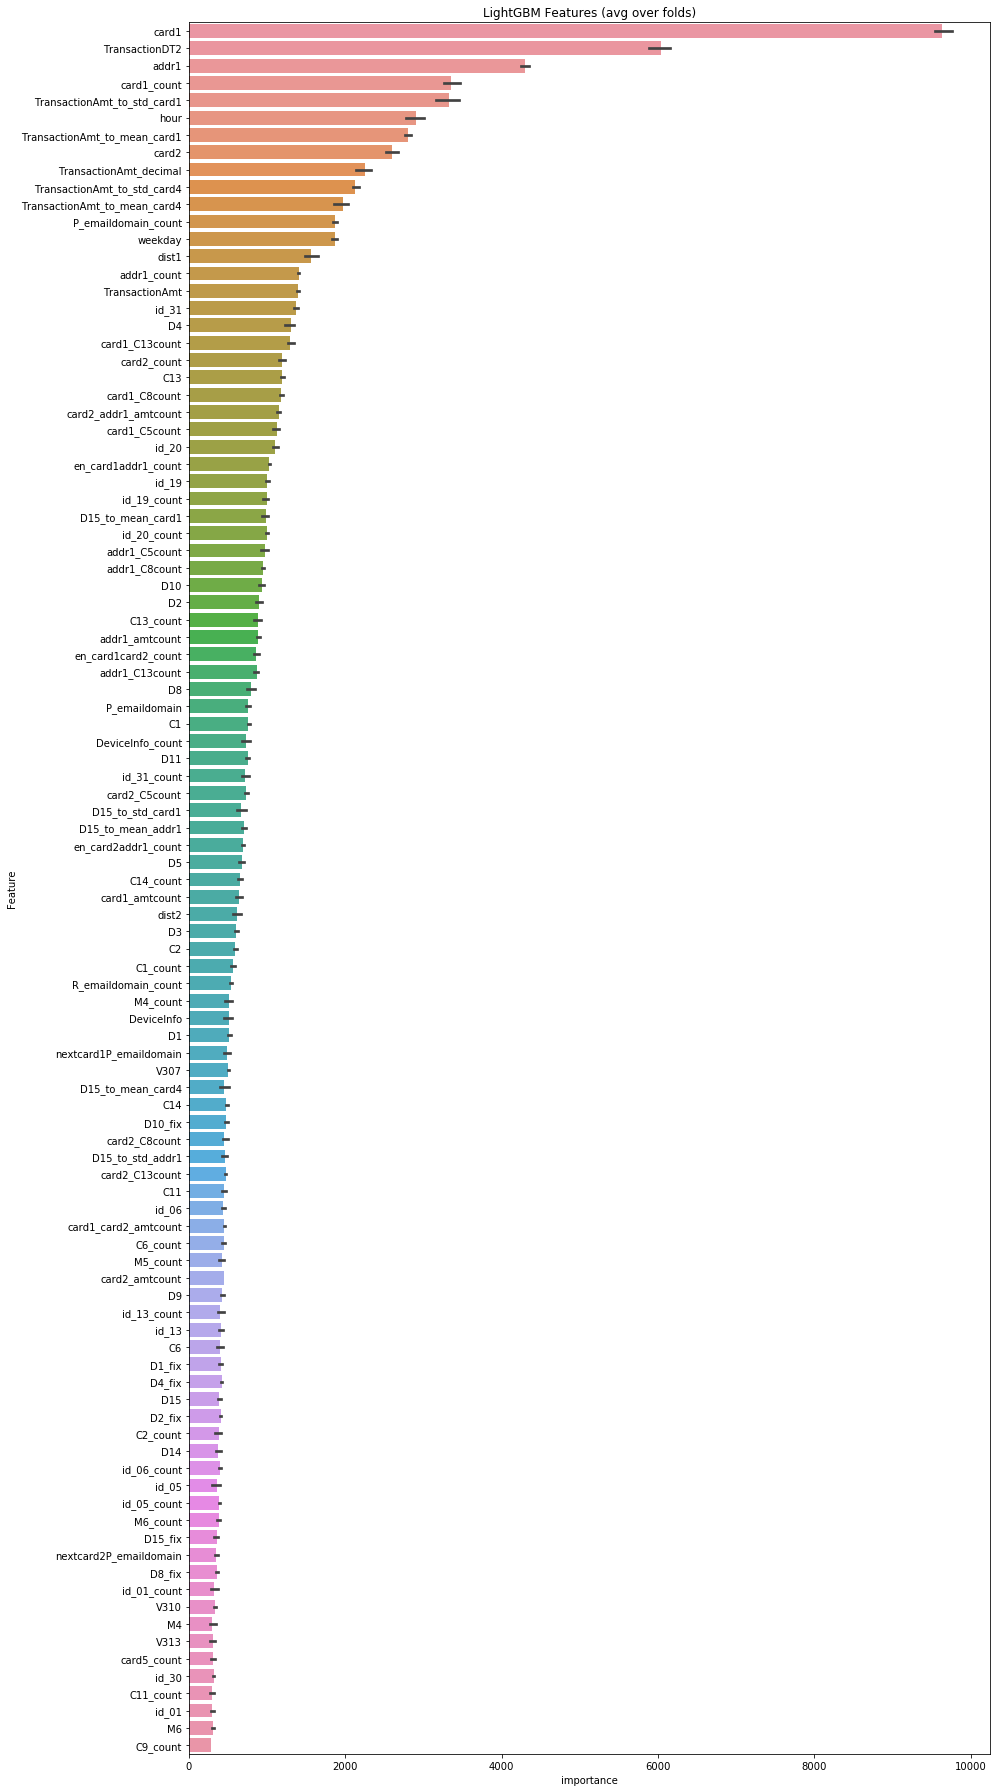

In [32]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [33]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if (x not in col_del ) and x not in []]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss',
                                min_data_in_leaf=15,l2_leaf_reg=3.0
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
    best_iter = num_rounds - 100
    y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    best_iter = num_rounds - 200
    y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

503
['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6146185	total: 1.34s	remaining: 15m 36s
30:	learn: 0.0890979	total: 40.5s	remaining: 14m 33s
60:	learn: 0.0631687	total: 1m 20s	remaining: 14m 8s
90:	learn: 0.0535622	total: 2m 2s	remaining: 13m 37s
120:	learn: 0.0484190	total: 2m 42s	remaining: 12m 56s
150:	learn: 0.0448245	total: 3m 22s	remaining: 12m 14s
180:	learn: 0.0421196	total: 4m 2s	remaining: 11m 33s
210:	learn: 0.0405386	total: 4m 41s	remaining: 10m 52s
270:	learn: 0.0375667	total: 6m	remaining: 9m 31s
300:	learn: 0.0363251	total: 6m 40s	remaining: 8m 50s
330:	learn: 0.0350747	total: 7m 19s	remaining: 8m 10s
360:	learn: 0.0337764	total: 7m 59s	remaining: 7m 30s
390:	learn: 0.0324869	total: 8m 38s	remaining: 6m 49s
420:	learn: 0.0313467	total: 9m 18s	remaining: 6m 10s
450:	learn: 0.0301867	total: 9m 57s	remaining: 5m 29s
480:	learn: 0.0291336	total:

In [34]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


debug: 0.9349693339109066 0.0820568411582461
debug: 0.9262919196023802 0.09738864262410253
debug: 0.9262018413531233 0.09137954146974697
debug: 0.9377470360762815 0.08212705388439605
debug: 0.9397144827821668 0.0813447301701318
debug: 0.9404079400939878 0.08025684946142951
debug: 0.9405523233434976 0.08164357429439802


In [ ]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    

debug: 0.9349693339109066 0.0820568411582461
debug: 0.9262919196023802 0.09738864262410253
debug: 0.9262018413531233 0.09137954146974697
debug: 0.9377470360762815 0.08212705388439605
debug: 0.9397144827821668 0.0813447301701318
debug: 0.9404079400939878 0.08424627721591094
debug: 0.9404492886189526 0.08424627721591094


In [ ]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline12.csv')
else:
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3
    sample_submission.to_csv('simple_ensemble12.csv')
